# EMNIST character classification by class


## Download dataset and inflate

In [1]:
# Check if already downloaded
check = !if [ -d 'dataset/' ]; then echo "1" ; else echo "0"; fi
if (check[0] is '0' ):
  !mkdir dataset
  !wget 'https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip'
  !unzip matlab.zip -d /content/dataset

--2020-04-13 04:24:28--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 129.6.13.51, 2610:20:6b01:4::36
Connecting to www.itl.nist.gov (www.itl.nist.gov)|129.6.13.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743900280 (709M) [application/zip]
Saving to: ‘matlab.zip’

matlab.zip          100%[===================>] 709.44M  33.2MB/s    in 22s     

2020-04-13 04:24:51 (32.0 MB/s) - ‘matlab.zip’ saved [743900280/743900280]

Archive:  matlab.zip
  inflating: /content/dataset/matlab/emnist-balanced.mat  
  inflating: /content/dataset/matlab/emnist-byclass.mat  
  inflating: /content/dataset/matlab/emnist-bymerge.mat  
  inflating: /content/dataset/matlab/emnist-digits.mat  
  inflating: /content/dataset/matlab/emnist-letters.mat  
  inflating: /content/dataset/matlab/emnist-mnist.mat  


## Importing libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
# Check if GPU is available
!nvidia-smi

Mon Apr 13 05:45:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Load EMNIST Characters dataset by Class
Introduced by https://arxiv.org/abs/1702.05373v1 downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset (Matlab format dataset). The matlab format dataset can be conveniently imported with scipy.io.loadmat.

In [0]:
from scipy import io as spio
emnist = spio.loadmat("/content/dataset/matlab/emnist-byclass.mat")

In [0]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

In [0]:
# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

In [6]:
# store labels for visualization
train_labels = y_train
test_labels = y_test

print (x_train.shape)
print (y_train.shape)

(697932, 784)
(697932, 1)


In [7]:
# Preprocess input data, reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1, order="A")
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1, order="A")

# normalized by 255
x_train /= 255
x_test /= 255

x_train.shape

(697932, 28, 28, 1)

In [8]:
from tensorflow.keras.utils import to_categorical

# Preprocess class labels
## EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
## Convert 1-dimensional class arrays to 62-dimensional class matrices

number_classes = 62

y_train = to_categorical(y_train, number_classes)
y_test = to_categorical(y_test,  number_classes)

print (y_train.shape)
print (y_test.shape)

(697932, 62)
(116323, 62)


## EDA

In [0]:
class_idx = ['0','1','2','3','4','5','6','7','8','9',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

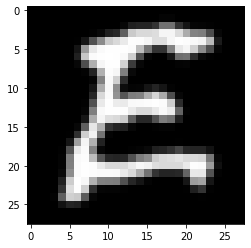

In [10]:
# which sample to look at
samplenum = 11500
img = x_train[samplenum]

# visualize image
plt.imshow(img[:,:,0], cmap='gray')

In [11]:
# show label for sample image
index = train_labels[samplenum][0]
class_idx[index]

'E'

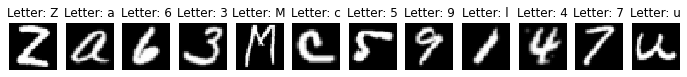

In [12]:
# visualize train samples
fig = plt.figure(figsize=(12,6))
for i in range(12):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]                                        
  plt.imshow(img[:,:,0], cmap='gray', interpolation='none')  # prints image
  index = train_labels[i][0]
  plt.title("Letter: " + str( class_idx[ index ] ))          # adds title to the letter or number

## Data augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 512
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_last')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

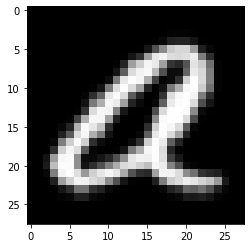

In [15]:
# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[:,:,0], cmap='gray')

In [16]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(28, 28, 1)

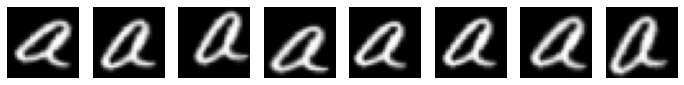

In [17]:
# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[:,:,0], cmap='gray') # images are stored as (img_size, image_size, channel)  to print it we should call it img [;,;,0]

## Build the network

In [0]:
import os                   
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization

In [19]:
print(x_train.shape)
print(len(y_train))

(697932, 28, 28, 1)
697932


In [20]:
#Define the Model
model = Sequential()

#Layer 1
model.add(Conv2D(32, (3, 3), use_bias = False, input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#Layer 2
model.add(Conv2D(64, (3, 3), use_bias = False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

#Layer 3
model.add(Conv2D(64, (3, 3), use_bias = False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

#Dropout layer
model.add(Dropout(0.2))

#Layer 4
model.add(Conv2D(128, (3, 3), use_bias = False))
model.add(BatchNormalization())
model.add(Activation('relu'))

#Dropout layer
model.add(Dropout(0.4))

#Output Layer
model.add(Conv2D(62, (3,3), use_bias = False))
model.add(Flatten())
model.add(Activation('softmax'))

#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        288       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0

## Compile the network

In [0]:
# Compile model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

## Train the model

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
batch_size = 128
epochs = 30
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=1, save_best_only=True, 
                               monitor="val_accuracy")

# Fit model on training data
history = model.fit(x_train, y_train,
                    batch_size, 
                    epochs, 
                    verbose=1, 
                    callbacks = [checkpointer], 
                    validation_data=(x_test, y_test))

Epoch 1/30
5453/5453 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.8261
Epoch 00001: val_accuracy improved from -inf to 0.85899, saving model to model.h5
5453/5453 [==============================] - 41s 8ms/step - loss: 0.5098 - accuracy: 0.8261 - val_loss: 0.3859 - val_accuracy: 0.8590
Epoch 2/30
5451/5453 [============================>.] - ETA: 0s - loss: 0.4037 - accuracy: 0.8534
Epoch 00002: val_accuracy improved from 0.85899 to 0.86713, saving model to model.h5
5453/5453 [==============================] - 42s 8ms/step - loss: 0.4037 - accuracy: 0.8534 - val_loss: 0.3637 - val_accuracy: 0.8671
Epoch 3/30
5448/5453 [============================>.] - ETA: 0s - loss: 0.3832 - accuracy: 0.8596
Epoch 00003: val_accuracy improved from 0.86713 to 0.87133, saving model to model.h5
5453/5453 [==============================] - 41s 8ms/step - loss: 0.3832 - accuracy: 0.8596 - val_loss: 0.3475 - val_accuracy: 0.8713
Epoch 4/30
5451/5453 [============================>.

## Plot training history

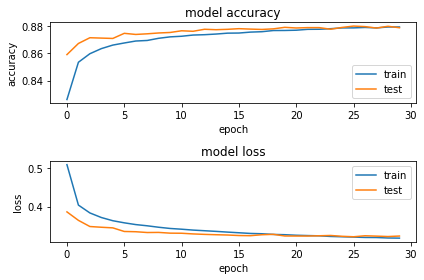

In [23]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

## Evaluate final accuracy

In [25]:
# Evaluate model on test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print ('Test loss ', loss )
print ('Test accuracy ', accuracy )

Test loss  0.3225385844707489
Test accuracy  0.8786482214927673


## Evaluate model performance

In [0]:
# create predictions on the test set
predicted_classes = np.argmax(model.predict(x_test), axis=-1)

In [27]:
# Reshape test labels
print (test_labels.shape )
reshape = str(test_labels.shape).split(',')
reshape = int(reshape[0][1:])
test_labels = test_labels.reshape(reshape)
test_labels.shape

(116323, 1)


(116323,)

In [28]:
# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


102207  classified correctly
14116  classified incorrectly


### Visualize 12 correct prediction

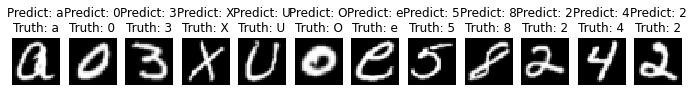

In [29]:
fig = plt.figure(figsize=(12,6))
for i, correct in enumerate(correct_indices[:12]):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]                                        
  plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')  # prints image
  plt.title(
      'Predict: ' + str(class_idx[predicted_classes[correct]]) +
      '\nTruth: ' + str(class_idx[test_labels[correct]])
  )

### Visualize 12 incorrect prediction

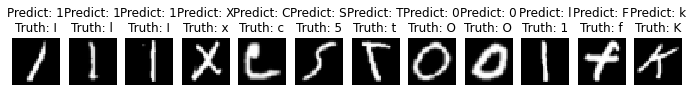

In [30]:
fig = plt.figure(figsize=(12,6))
for i, correct in enumerate(incorrect_indices[:12]):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]                                        
  plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')  # prints image
  plt.title(
      'Predict: ' + str(class_idx[predicted_classes[correct]]) +
      '\nTruth: ' + str(class_idx[test_labels[correct]])
  )

##Predict image

Text(0.5, 1.0, 'Letter: 5')

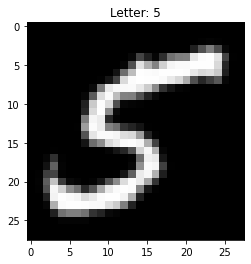

In [33]:
import random
image_index = random.randint(1,len(x_test))

image = x_test[image_index] # show label for sample image
plt.imshow(image[:,:,0], cmap='gray', interpolation='none')
image = np.expand_dims(image, axis=0)
scores = model.predict(image)

index = np.argmax(scores)
plt.title("Letter: " + str( class_idx[ index ] ))